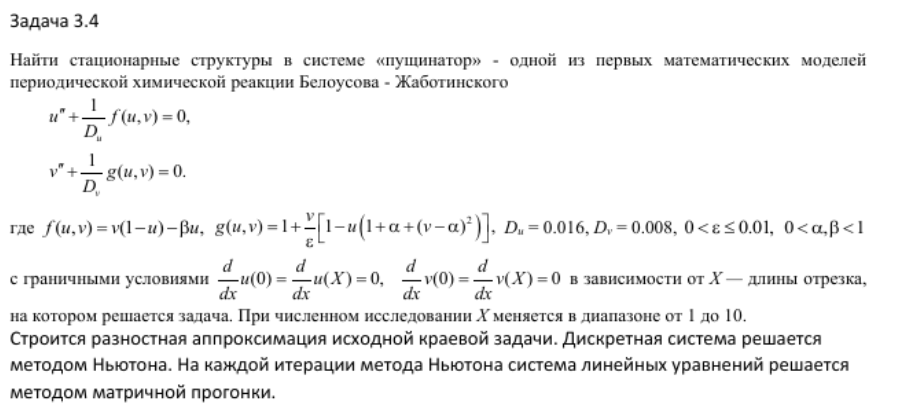

Список литературы:

**[1]** КОСАРЕВ В. И. 12 лекций по вычислительной математике (вводный
курс). - Изд. 3-е, испр. и доп. - М.: Физматкнига, 2013. - 240 с.
ISBN 978-5-89155-214-2

**[2]** Типовые задачи заданий по вычислительной математике.
VI семестр, ОДУ. Решения, указания, ответы : учебно-метод. пособие /
сост. Р. С. Пастушков. – М. : МФТИ, 2015. – 48 с

**[3]** Численные методы, Книга 2, Методы математической физики, Калиткин Н.Н., Корякин П.В., 2013.


Построим разностную аппроксимацию задачи и граничных условий второго порядка:

После аппроксимации граничных условий получаем следующую СЛАУ для сеточной функции $u$. Аналогичная системы с соответствующими функциями возникает и для $v$
$$\large \begin{cases}
\frac{u_{1} - u_{0}}{h} = 0 - \frac{h}{2}\frac{1}{D_u}f(u_{0}, v_{0})\\
\frac{u_{k+1} - 2u_{k} + u_{k-1}}{h^2} + \frac{1}{D_u}f(u_{k}, v_{k}) = 0,& k = 1, N-1\\
\frac{u_{N-1} - u_{N}}{h} = 0 - \frac{h}{2}\frac{1}{D_u}f(u_{N}, v_{N})
\end{cases}$$

Система нелинейных уравнений решается методом ньютоновских итераций. 

Критерий останова: превышение числа шагов `n_max=40`

Для компоненты $u(x)$ строятся графики для различной мелкости разбиения расчетной области. Мелкость увеличивается в два раза. Это позволит применить метод Ричардсона оценки погрешности.

# Результаты и обсуждение задачи:

В этой задаче не получилось применить метод матричной прогонки. Решение и без того получается перегруженным технически.

Возникающая блочная трехдиагноальная матрица плохо обусловлена:
`cond > 10 000`

У уравнения есть гарантированно два состояния, не только не зависящих от времени, но также и от координаты $x$. Они находятся как решения системы. Далее они отмечены красными точками на фазовой диаграмме.

$$\large \begin{cases}
f(\hat u, \hat v) = 0\\
g(\hat u, \hat v) = 0\\
\end{cases}$$





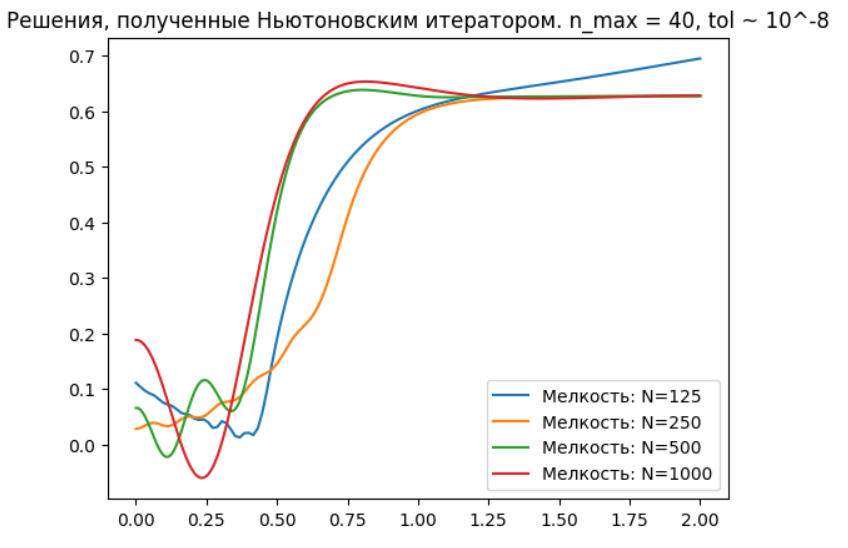

In [ ]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import axes
import matplotlib.image as mpimg
from celluloid import Camera
from IPython.display import Image
import scipy 

from tqdm import tqdm
from numba import njit

In [ ]:
alpha = 0.5
beta = 0.5
epsilon = 0.01

In [ ]:
 class pushinator_solver:

  def __init__(self, alpha = 0.5, beta = 0.5, epsilon = 0.01, Du = 0.016, Dv = 0.008,
               dx = 1 / 100):
    self.alpha = alpha
    self.beta = beta
    self.epsilon = epsilon
    self.Du = Du
    self.Dv = Dv

    self.dx = dx

  
  def ff(self, y):
    '''
    Якобиан правой часть уравнения
      
    :param alpha, betta, epsilon: параметр задачи
    :const Du, Dv: константы задачи
    :return: вектор решения размерности (2N+1)
    '''

    u = y[::2]
    v = y[1::2]

    dfdu = -v - self.beta
    dfdv = 1 - u
    dgdu = - v / self.epsilon * (1 + self.alpha + (v - self.alpha)**2)
    dgdv = (1 - u*(self.alpha**2 + self.alpha + 3*v**2 - 4*self.alpha*v + 1))/self.epsilon

    return dfdu / self.Du, dfdv / self.Du, dgdu / self.Dv, dgdv / self.Dv

  
  def F(self, u, v):
      return v*(1-u) - self.beta*u

  
  def G(self, u, v):
      return 1 + v/self.epsilon * (1 - u*(1 + self.alpha + (v - self.alpha)**2))

  def pushinator1d(self, y):
    """
    Differential equations for the 1-D Jabotinskij equations.
    """
    # The vectors u and v are interleaved in y.  We define
    # views of u and v by slicing y.
    u = y[::2]
    v = y[1::2]

    # dydt is the return value of this function.
    dydt = np.empty_like(y)

    # Just like u and v are views of the interleaved vectors
    # in y, dudt and dvdt are views of the interleaved output
    # vectors in dydt.
    dudt = dydt[::2]
    dvdt = dydt[1::2]

    #rint(len(u))
    # Compute du/dt and dv/dt.  The end points and the interior points
    # are handled separately.
    dudt[0]    = self.F(u[0],    v[0]   ) / self.Du + (-2.0*u[0] + 2.0*u[1]) / self.dx**2
    dudt[1:-1] = self.F(u[1:-1], v[1:-1]) / self.Du + np.diff(u,2) / dx**2
    dudt[-1]   = self.F(u[-1],   v[-1]  ) / self.Du + (- 2.0*u[-1] + 2.0*u[-2]) / self.dx**2
    dvdt[0]    = self.G(u[0],    v[0]   ) / self.Dv + (-2.0*v[0] + 2.0*v[1]) / self.dx**2
    dvdt[1:-1] = self.G(u[1:-1], v[1:-1]) / self.Dv + np.diff(v,2) / self.dx**2
    dvdt[-1]   = self.G(u[-1],   v[-1]  ) / self.Dv + (-2.0*v[-1] + 2.0*v[-2]) / self.dx**2

    return dydt
  
  def jacobian(self, y):
    '''
    Якобиан 
      
    :param alpha, betta, epsilon: параметр задачи
    :const Du, Dv: константы задачи
    :return: вектор решения размерности (2N+1)
    '''

    u = y[::2]
    v = y[1::2]

    N = len(y)

    dfdu, dfdv, dgdu, dgdv = self.ff(y)

    #верно
    upper_1 = np.zeros(shape = N - 1)
    upper_1[::2] = dfdv

    #верно
    upper_2 = np.zeros(shape = N - 2)
    upper_2[:2] = 2 / self.dx**2
    upper_2[2:-2] = 1 / self.dx**2
    upper_2[-2:] = 1 / self.dx**2

    #верно
    down_1 = np.zeros(shape = N - 1)
    down_1[::2] = dgdu

    #верно
    down_2 = np.zeros(shape = N - 2)
    down_2[:2] = 1 / self.dx**2
    down_2[2:-2] = 1 / self.dx**2
    down_2[-2:] = 2 / self.dx**2

    #верно
    center = np.zeros(shape = N)
    center[::2] = -2 / self.dx**2 + dfdu
    center[1::2] = -2 / self.dx**2 + dgdv

    return np.diagflat(down_2, -2) +\
          np.diagflat(down_1, -1) +\
          np.diagflat(center) +\
          np.diagflat(upper_1, 1) +\
          np.diagflat(upper_2, 2)
  
  def newton(self, y, n_step = 5, choose = False):
    results = np.copy(y)
    for i in tqdm(range(n_step)):
      A = self.jacobian(y = y)
      b =  self.pushinator1d(y = y) 

      dy = np.linalg.inv(A) @ b

      if choose:
        tau  = self.choose_tau(y, dy)
      else:
        tau = 1

      y = y - tau * dy

      results = np.vstack((results, y))
    return results

  def choose_tau(self, y, dy):
    tau = 1
    for i in range(10):
      norm_a = np.linalg.norm(self.pushinator1d(y))
      norm_b = np.linalg.norm(self.pushinator1d(y - dy*tau))
      if norm_b < norm_a:
        #print(norm_a)
        return tau
      else:
        tau /= 2
    return tau
  
  def transform_matrix(self, A):
    '''
    Индексы
    '''
    N = len(A) // 2
    Ia=[i for i in range(N   )]
    Ib=[i for i in range(N-1 )]
    Ic=[i for i in range(N-1 )]
    '''
    Матрицы 2*2
    '''
    Al = [A[2*i     : 2*i + 2,
            2*i     : 2*i + 2] for i in range(N)]
    Bl = [A[2*i + 2 : 2*i + 4,
            2*i     : 2*i + 2] for i in range(N-1)]
    Cl = [A[2*i     : 2*i + 2,
            2*i + 2 : 2*i + 4] for i in range(N-1)]
    
    BTD  = block_td(Al,Bl,Cl,Ia,Ib,Ic)
    # find all blocks of inverse
    #iBTD_dense = Blocksparse2Numpy(iBTD, BTD.all_slices)

    return BTD #iBTD_dense

In [ ]:
def perform_decreasing_step(y, a, N, epsilon):
  sol = []

  for i in range(4):
    dx = a/N
    x = np.linspace(0, a, N+1)

    rng = np.random.default_rng()
    y = np.linspace(0, 1, 2*(N+1))

    solver = pushinator_solver(dx = a/N / 2**i, epsilon = epsilon, Du = 0.016, Dv = 0.008)
    results = solver.newton(y, n_step = 40, choose=True)

    sol.append(results[-1][::2])
    plt.plot(x, results[-1][::2], label=f'Мелкость: N={N}')
    N *= 2
  plt.legend()
  plt.title('Решения, полученные Ньютоновским итератором. n_max = 40, tol ~ 10^-8')

100%|██████████| 40/40 [00:43<00:00,  1.10s/it]


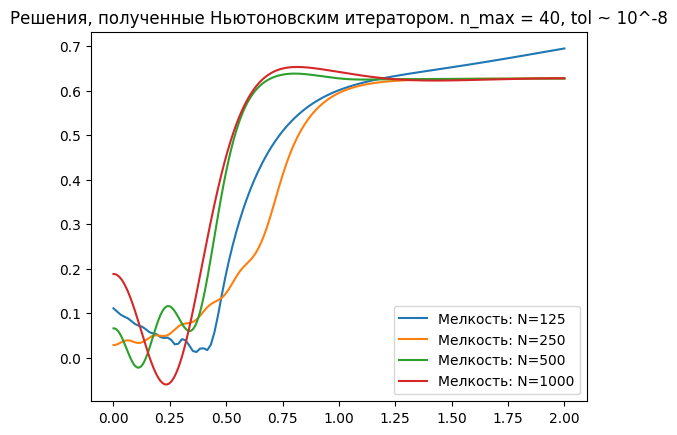

In [ ]:
y = np.linspace(0, 1, 2*(N+1))
perform_decreasing_step(step_0 = a/N, y=y)

100%|██████████| 40/40 [02:40<00:00,  4.01s/it]


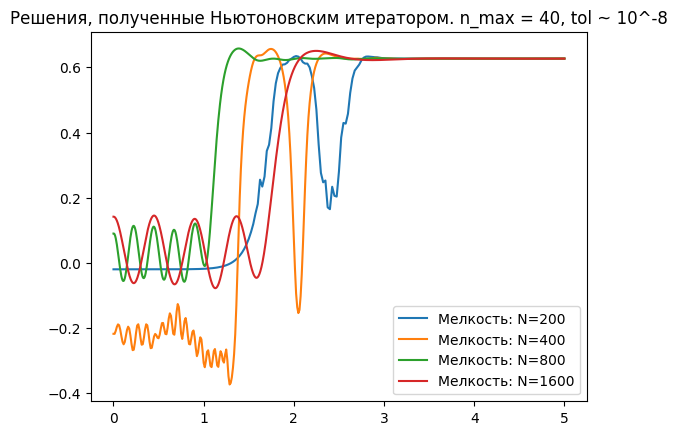

In [ ]:
N = 200
a = 5
y = np.linspace(0, 1, 2*(N+1))
perform_decreasing_step(y=y, a=a, N=N)

100%|██████████| 40/40 [00:24<00:00,  1.65it/s]


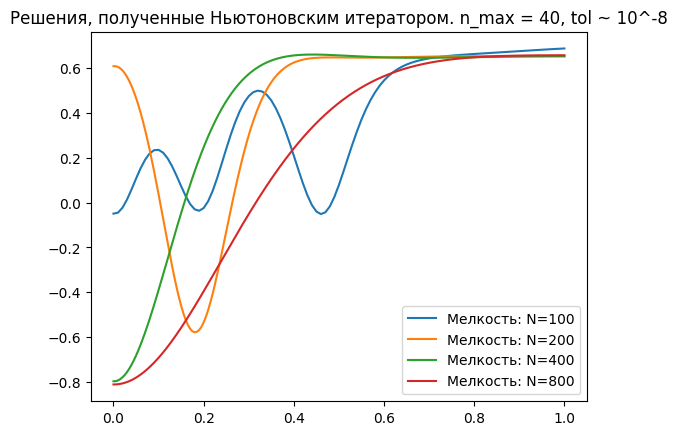

In [ ]:
N = 100
a = 1
y = np.linspace(0, 1, 2*(N+1))
perform_decreasing_step(y=y, a=a, N=N, epsilon=0.1)

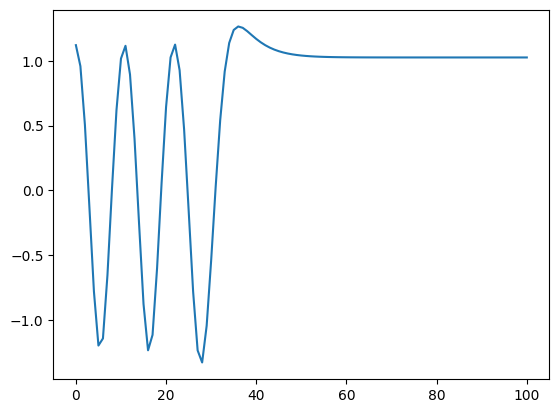

In [ ]:
plt.plot(v)

In [ ]:
#stiff = 153#15
a = 2
N = 100
dx = a/N
x = np.linspace(0, a, N+1)

rng = np.random.default_rng()
y = np.linspace(0, 1, 2*(N+1))
#y = np.ones(2*(N+1))
#y = rng.standard_normal(2*(N+1))
solver = pushinator_solver(dx = a/N, epsilon = 0.2, Du = 0.016, Dv = 0.008)
results = solver.newton(y, n_step = 40, choose=True)

100%|██████████| 40/40 [00:00<00:00, 89.88it/s]


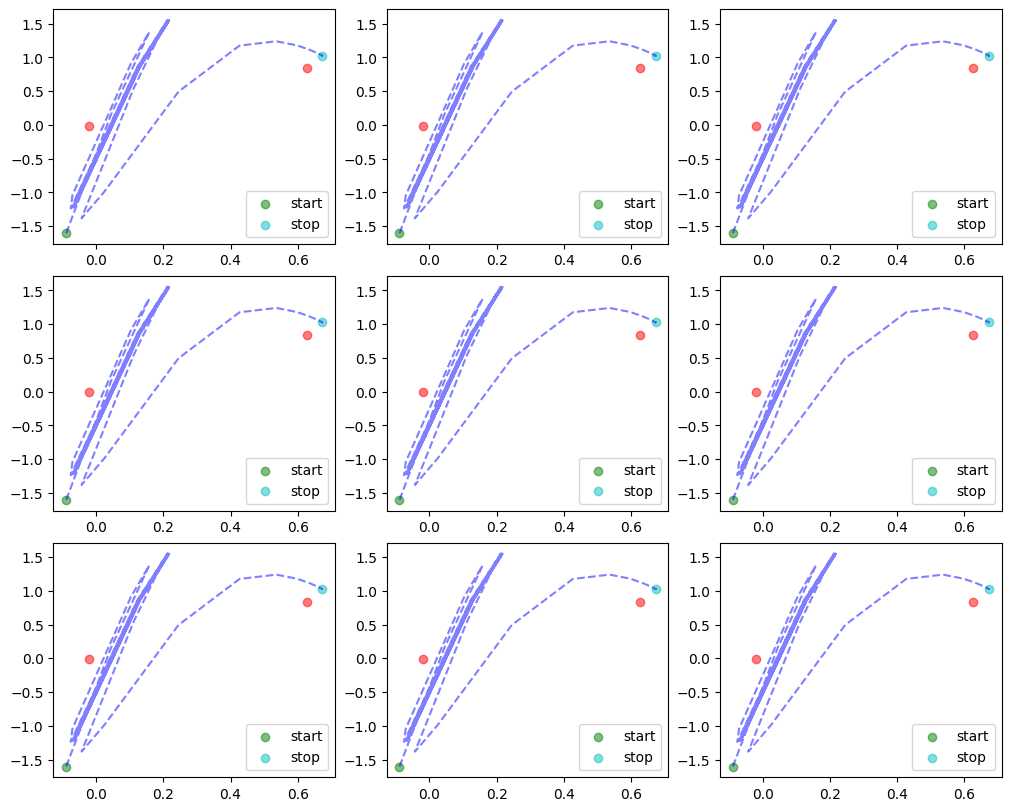

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8), layout='constrained')

for ax, y in zip(axs.flat, results[::-1]):
  u = y[::2]
  v = y[1::2]
  ax.scatter(u[0], v[0], c = 'g', alpha = 0.5, label = 'start')
  ax.scatter(u[-1], v[-1], c = 'c', alpha = 0.5, label = 'stop')

  ax.plot(u, v, c = 'b', ls = '--', alpha = 0.5)
  ax.scatter(0.6265, 0.8387, c = 'r', alpha = 0.5)
  ax.scatter(-0.01971054, -0.00966477, c = 'r', alpha = 0.5)

  ax.legend()
  #ax.set_ylim((np.mean(u) - 0.001, np.mean(u)+0.001))

In [ ]:
np.set_printoptions(precision=0, suppress=True, threshold=5)

In [ ]:
'''
Особые точки:
0.5 0.5
 0.6265,      0.8387
-0.01971054, -0.00966477
'''
solver = pushinator_solver(dx = a/N, epsilon = 0.1, Du = 0.016, Dv = 0.008, alpha = 0.05, beta = 0.5)

#y_star = np.array([-0.01971054, -0.00966477])
y_star = np.array([ 0.6265,      0.8387])
dfdu, dfdv, dgdu, dgdv = solver.ff(y_star)
dfdu, dfdv, dgdu, dgdv = dfdu[0], dfdv[0], dgdu[0], dgdv[0]
A = np.array([[0.,     1., 0.,  0.    ],
              [-dfdu, 0., 0.,  -dfdv],
              [0.,     0., 0.,  1.    ],
              [-dgdu, 0., 0., -dgdv]])

In [ ]:
J = np.array([[dfdu, dfdv],
              [dgdu, dgdv]])
np.linalg.det(J), np.linalg.eigvals(J)

(132576.60261762157, array([ -126., -1053.]))

In [ ]:
np.max(A)

30.645951875

In [ ]:
2/21850 / 0.01 * 10000

91.53318077803203

In [ ]:
l

array([     0.,      6.,     -6., -12936.])

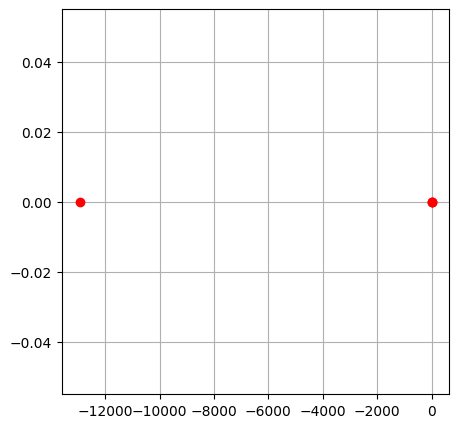

In [ ]:
l = np.linalg.eigvals(A)

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.real(l), np.imag(l),'ro')
ax.grid(True)